In [1]:
!pip install --upgrade keras
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(style='darkgrid')
from keras.models import Model,Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout
from keras.optimizers import Adam
from keras.applications import EfficientNetV2L
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.src.legacy.preprocessing.image import ImageDataGenerator


2024-05-04 01:09:23.848036: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 01:09:23.848129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 01:09:24.020955: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# getting the data ready


In [2]:
path='/kaggle/input/utkface-new/UTKFace'
images=[]
age=[]
gender=[]

In [3]:
def get_data(path):
    """
    This function preprocesses the images in the given path and appends
    them to the respective lists for images, age, and gender.

    Args:
        path (str): The path to the folder containing the images.
    """
    # Iterate over all files in the given path
    for img in tqdm(os.listdir(path)):
        # Extract the age and gender from the filename
        # Extract the age from the filename
        ages = int(img.split('_')[0]) 
        # Extract the gender from the filename
        genders = int(img.split('_')[1]) 

        # Check if the age is not greater than 100 and the gender is either '0' or '1'
        # This condition ensures that only valid images are processed
        if ages <= 100 and genders in [0, 1]:
            # Read the image
            # Join the path and the filename to get the complete image path
            img_path = os.path.join(path, img)
            # Read the image
            img = cv2.imread(img_path)
            # Resize the image to 96x96 pixels
            img = cv2.resize(img, (96, 96)) 
            # Convert color from BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            

            # Append the image, age, and gender to their respective lists
            images.append(np.array(img))
            age.append(np.array(ages))
            gender.append(np.array(genders))
            

In [4]:
get_data(path)

100%|██████████| 23708/23708 [01:46<00:00, 222.27it/s]


In [5]:
len(os.listdir(path)),len(images),len(age),len(gender)


(23708, 23687, 23687, 23687)

In [6]:
images=np.array(images)/255
age=np.array(age)
gender=np.array(gender)

Text(0.5, 1.0, '1')

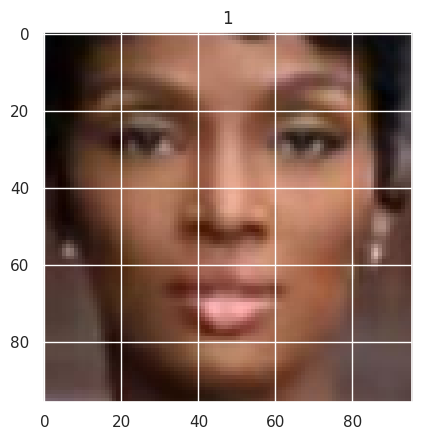

In [7]:
plt.imshow(images[1])
plt.title(gender[1])

In [8]:
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(images, age, test_size=0.2, stratify=age,shuffle=True,random_state=42)
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(images, gender, test_size=0.2, stratify=gender,shuffle=True,random_state=42)

In [9]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_age = datagen.flow(X_train_age, y_train_age, batch_size=16)

test_age = test_datagen.flow(
        X_test_age, y_test_age,
        batch_size=16)



In [12]:
# def pretrained_model(base_model, input_shape, weights='imagenet'):
#     """Create a pretrained model with frozen layers."""
#     model = base_model(include_top=False, input_shape=input_shape, weights=weights)
#     for layer in model.layers:
#         layer.trainable = False
#     return model

# base_model=pretrained_model(EfficientNetV2L, input_shape=(96, 96,3))

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [13]:
# x = Flatten()(base_model.output)
# x=Dense(256,activation='relu')(x)

# output = Dense(1, activation='linear')(x) 
    
# age_model = Model(inputs=base_model.input, outputs=output)

In [14]:
# age_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 96, 96, 3) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 48, 48,    │        864 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 48, 48,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 48, 48,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 48, 48,    │      9,216 │ stem_activation[… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 48, 48,    │        128 │ block1a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 48, 48,    │          0 │ block1a_project_… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 48, 48,    │          0 │ block1a_project_… │
│                     │ 32)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 48, 48,    │      9,216 │ block1a_add[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 48, 48,    │        128 │ block1b_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 48, 48,    │          0 │ block1b_project_… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 48, 48,    │          0 │ block1b_project_… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 48, 48,    │          0 │ block1b_drop[0][… │
│                     │ 32)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_co… │ (None, 48, 48,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_bn  │ (None, 48, 48,    │        128 │ block1c_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_ac… │ (None, 48, 48,    │          0 │ block1c_project_

 Total params: 120,696,481 (460.42 MB)

 Trainable params: 2,949,633 (11.25 MB)

 Non-trainable params: 117,746,848 (449.17 MB)

In [10]:
def compile_model(model, optimizer, learning_rate, loss, metrics):

    """
    Compiles the given model with the specified optimizer, learning rate,
    loss and metrics.

    Args:
        model (Model): The model to be compiled.
        optimizer (Optimizer): The optimizer to be used.
        learning_rate (float): The learning rate for the optimizer.
        loss (str): The loss function to be used.
        metrics (list): The evaluation metrics to be used.

    Returns:
        Model: The compiled model.
    """
    # Compile the model using the specified optimizer, learning rate,
    # loss and metrics
    model.compile(optimizer=optimizer(learning_rate),
                  loss=loss,
                  metrics=[metrics])
    
    # Return the compiled model
    return model




def train_model(model, train_generator,test_generator, batch_size, epochs, learning_rate,
                patience_early_stopping, patience_reduce_lr_on_plateau):
    """
    Train the model using the given training and testing data.

    Args:
        model (Model): The model to be trained.
        X_train (numpy.ndarray): The training images.
        y_train (numpy.ndarray): The training labels.
        X_test (numpy.ndarray): The testing images.
        y_test (numpy.ndarray): The testing labels.
        batch_size (int): The batch size for training.
        epochs (int): The number of epochs to train for.
        learning_rate (float): The learning rate for the optimizer.
        patience_early_stopping (int): The patience value for the early stopping monitor.
        patience_reduce_lr_on_plateau (int): The patience value for the reduce learning rate on plateau monitor.

    Returns:
        History: The history of the training process.
    """
    # Initialize the early stopping and reduce learning rate on plateau monitors
    # The early stopping monitor stops training when the validation loss stops improving
    # The reduce learning rate on plateau monitor reduces the learning rate when the validation loss stops improving
    early_stopping_monitor = EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        patience=patience_early_stopping,  # If the validation loss doesn't improve for this many epochs, stop training
        restore_best_weights=True  # Restore the weights from the best epoch
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',  # Monitor the validation loss
        factor=0.9,  # Factor by which to reduce the learning rate
        patience=patience_reduce_lr_on_plateau,  # If the validation loss doesn't improve for this many epochs, reduce the learning rate
        min_lr=learning_rate  # The minimum learning rate
    )

    # Train the model and return the history and the trained model
    history = model.fit(
        train_generator,  # Training data
        batch_size=batch_size,  # Batch size
        epochs=epochs,  # Number of epochs
        validation_data=test_generator,  # Validation data
        callbacks=[reduce_lr, early_stopping_monitor]  # Callbacks
    )

    return history



def train_model_2(model, train_data,train_labels,test_data,test_labels, batch_size, epochs, learning_rate,
                patience_early_stopping, patience_reduce_lr_on_plateau):
    """
    Train the model using the given training and testing data.

    Args:
        model (Model): The model to be trained.
        X_train (numpy.ndarray): The training images.
        y_train (numpy.ndarray): The training labels.
        X_test (numpy.ndarray): The testing images.
        y_test (numpy.ndarray): The testing labels.
        batch_size (int): The batch size for training.
        epochs (int): The number of epochs to train for.
        learning_rate (float): The learning rate for the optimizer.
        patience_early_stopping (int): The patience value for the early stopping monitor.
        patience_reduce_lr_on_plateau (int): The patience value for the reduce learning rate on plateau monitor.

    Returns:
        History: The history of the training process.
    """
    # Initialize the early stopping and reduce learning rate on plateau monitors
    # The early stopping monitor stops training when the validation loss stops improving
    # The reduce learning rate on plateau monitor reduces the learning rate when the validation loss stops improving
    early_stopping_monitor = EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        patience=patience_early_stopping,  # If the validation loss doesn't improve for this many epochs, stop training
        restore_best_weights=True  # Restore the weights from the best epoch
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',  # Monitor the validation loss
        factor=0.9,  # Factor by which to reduce the learning rate
        patience=patience_reduce_lr_on_plateau,  # If the validation loss doesn't improve for this many epochs, reduce the learning rate
        min_lr=learning_rate  # The minimum learning rate
    )

    # Train the model and return the history and the trained model
    history = model.fit(
        train_data,train_labels,  # Training data
        batch_size=batch_size,  # Batch size
        epochs=epochs,  # Number of epochs
        validation_data=(test_data,test_labels),  # Validation data
        callbacks=[reduce_lr, early_stopping_monitor]  # Callbacks
    )

    return history


In [16]:
# compile_model(age_model,Adam, 0.0001, 'mean_squared_error', 'mae')
# age_history= train_model(age_model, train_age, test_age, 16, 50, 0.0001, 4, 1)



In [13]:
agemodel = Sequential()
agemodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)))
agemodel.add(MaxPool2D((2,2)))
agemodel.add(Conv2D(64, (3,3), activation='relu'))
agemodel.add(MaxPool2D((2,2)))
agemodel.add(Conv2D(128, (3,3), activation='relu'))
agemodel.add(MaxPool2D((2,2)))
agemodel.add(Conv2D(512, (3,3), activation='relu'))
agemodel.add(MaxPool2D((2,2)))
agemodel.add(Flatten())
agemodel.add(Dense(256, activation='relu'))
agemodel.add(Dense(128, activation='relu'))
agemodel.add(Dropout(0.3))
agemodel.add(Dense(1, activation='linear'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
agemodel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 512)      │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,814,017 (10.73 MB)

 Trainable params: 2,814,017 (10.73 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
compile_model(agemodel,Adam, 0.0001, 'mean_squared_error', 'mae')
age_history_2= train_model(agemodel, train_age, test_age, 16, 50, 0.0001, 4, 1)


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   5/1185 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 1469.8751 - mae: 34.0258  

I0000 00:00:1714774870.283080     159 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714774870.305154     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 705/1185 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 662.7556 - mae: 19.7726

W0000 00:00:1714774901.571035     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1185/1185 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 582.1469 - mae: 18.4422

W0000 00:00:1714774920.739797     160 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1185/1185 ━━━━━━━━━━━━━━━━━━━━ 64s 44ms/step - loss: 582.0355 - mae: 18.4404 - val_loss: 398.9530 - val_mae: 14.9045 - learning_rate: 1.0000e-04
Epoch 2/50


W0000 00:00:1714774922.534236     160 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1185/1185 ━━━━━━━━━━━━━━━━━━━━ 47s 39ms/step - loss: 416.5334 - mae: 15.7678 - val_loss: 445.8559 - val_mae: 15.2917 - learning_rate: 1.0000e-04
Epoch 3/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 47s 39ms/step - loss: 400.7979 - mae: 15.4441 - val_loss: 378.8954 - val_mae: 15.1977 - learning_rate: 1.0000e-04
Epoch 4/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 47s 39ms/step - loss: 390.4321 - mae: 15.3091 - val_loss: 375.3429 - val_mae: 15.2311 - learning_rate: 1.0000e-04
Epoch 5/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 47s 39ms/step - loss: 396.0929 - mae: 15.3647 - val_loss: 376.4084 - val_mae: 15.5743 - learning_rate: 1.0000e-04
Epoch 6/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - loss: 378.0050 - mae: 15.0062 - val_loss: 363.2539 - val_mae: 14.3001 - learning_rate: 1.0000e-04
Epoch 7/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - loss: 372.6926 - mae: 14.8313 - val_loss: 340.6747 - val_mae: 13.9701 - learning_rate: 1.0000e-04
Epoch 8/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 47s 39ms/step - loss: 354.9958 - 

In [18]:
agemodel.evaluate(test_age)

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 112.2558 - mae: 7.5337


[111.9239273071289, 7.5194315910339355]

In [37]:
def plot_loss(history,num_epochs):
    plt.figure(figsize = (12, 6))
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss'] 
    epoch = range(1, num_epochs+1)
    sns.lineplot(x=epoch, y=train_loss, label = 'Training Loss')
    sns.lineplot(x=epoch, y=val_loss, label = 'Validation Loss')
    plt.title('Training and Validation Loss of the final model\n')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc = 'best')
    plt.show()
    

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

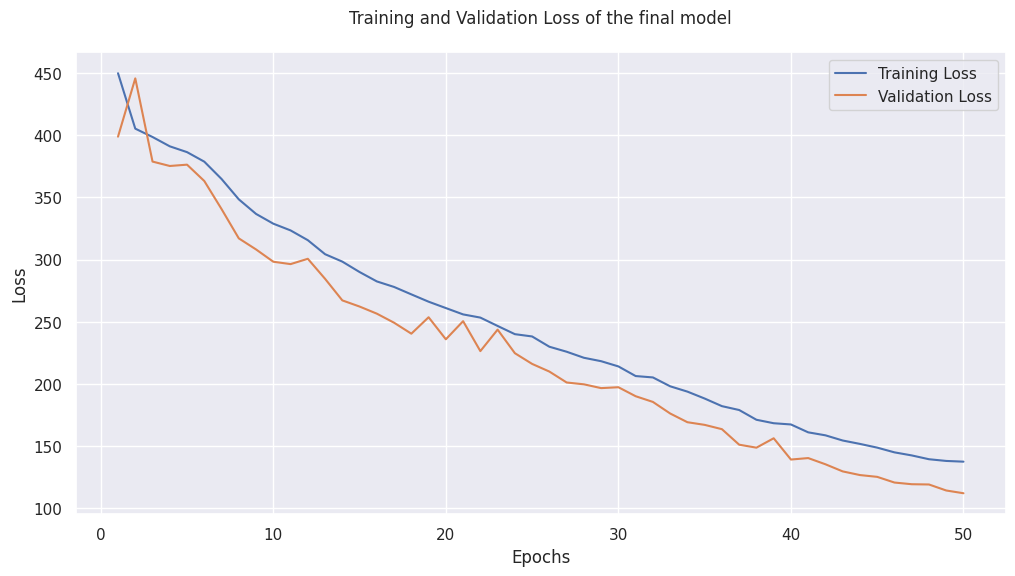

In [38]:
plot_loss(age_history_2,50)

TypeError: 'History' object is not subscriptable

In [19]:
agemodel.save('kaggle_age_model.h5')

In [40]:
test_images,test_labels=next(test_age)

In [41]:
age_prediction=agemodel.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


W0000 00:00:1714778737.373760     160 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [48]:
test_labels, age_prediction

(array([35, 50, 85, 53,  1, 23, 26, 50, 21, 29, 88, 26, 56, 27, 26, 12]),
 array([[38.03764  ],
        [60.4949   ],
        [69.22948  ],
        [48.444706 ],
        [ 3.0414119],
        [15.302543 ],
        [25.311007 ],
        [52.936527 ],
        [35.854855 ],
        [36.966156 ],
        [82.818954 ],
        [33.297264 ],
        [45.86617  ],
        [29.186054 ],
        [31.805492 ],
        [16.871075 ]], dtype=float32))

In [51]:
def plot_original_predicted(i):
    img=test_images[i]*255
    labl_original=test_labels[i]
    labl_predicted=age_prediction[i]
    plt.imshow(img,cmap='gray')
    plt.title(f'original age is {labl_original}\n the predicted age is {labl_predicted}')
    plt.xticks([])
    plt.yticks([])
    plt.show()

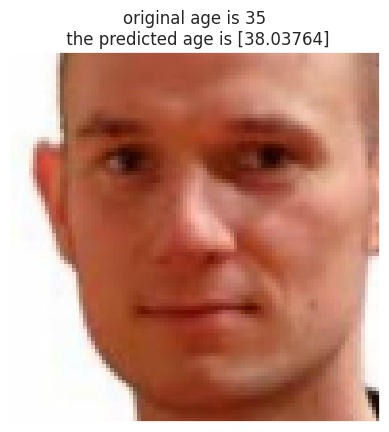

In [58]:
plot_original_predicted(0)

In [39]:
age_model=train_model(agemodel, train_age, test_age, 16, 6, 0.0001, 4, 1)

Epoch 1/6
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - loss: 132.1104 - mae: 8.4147 - val_loss: 109.9918 - val_mae: 7.6300 - learning_rate: 1.0000e-04
Epoch 2/6
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - loss: 128.5516 - mae: 8.3380 - val_loss: 110.8453 - val_mae: 7.4544 - learning_rate: 1.0000e-04
Epoch 3/6
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - loss: 125.4368 - mae: 8.2496 - val_loss: 105.0447 - val_mae: 7.3422 - learning_rate: 1.0000e-04
Epoch 4/6
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - loss: 132.1688 - mae: 8.3428 - val_loss: 118.3608 - val_mae: 8.1070 - learning_rate: 1.0000e-04
Epoch 5/6
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - loss: 126.3115 - mae: 8.2519 - val_loss: 104.7505 - val_mae: 7.5158 - learning_rate: 1.0000e-04
Epoch 6/6
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 46s 38ms/step - loss: 124.6359 - mae: 8.2096 - val_loss: 101.7647 - val_mae: 7.3419 - learning_rate: 1.0000e-04


## gender build

In [11]:
gender_model = Sequential([
Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
MaxPool2D((2,2)),
Conv2D(64, (3,3), activation='relu'),
MaxPool2D((2,2)),
Conv2D(128, (3,3), activation='relu'),
MaxPool2D((2,2)),
Conv2D(512, (3,3), activation='relu'),
MaxPool2D((2,2)),
Flatten(),
Dense(256, activation='relu'),
Dense(128, activation='relu'),
Dropout(0.3),
Dense(1, activation='sigmoid')
    
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
gender_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 512)      │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,814,017 (10.73 MB)

 Trainable params: 2,814,017 (10.73 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
compile_model(gender_model,Adam, 0.00001, 'binary_crossentropy', 'accuracy')
gender_history= train_model_2(gender_model, X_train_gender,y_train_gender,X_test_gender,y_test_gender, 64, 35, 0.0001, 4, 1)

Epoch 1/35
  7/297 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8662 - loss: 0.3607

W0000 00:00:1714785269.084863     194 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8284 - loss: 0.3936

W0000 00:00:1714785276.813134     194 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714785278.681026     194 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.8284 - loss: 0.3936 - val_accuracy: 0.8290 - val_loss: 0.3884 - learning_rate: 1.0000e-05
Epoch 2/35
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8315 - loss: 0.3855 - val_accuracy: 0.8335 - val_loss: 0.3745 - learning_rate: 1.0000e-05
Epoch 3/35
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8421 - loss: 0.3667 - val_accuracy: 0.8396 - val_loss: 0.3621 - learning_rate: 1.0000e-05
Epoch 4/35
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8505 - loss: 0.3477 - val_accuracy: 0.8476 - val_loss: 0.3575 - learning_rate: 1.0000e-05
Epoch 5/35
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8483 - loss: 0.3486 - val_accuracy: 0.8482 - val_loss: 0.3450 - learning_rate: 1.0000e-05
Epoch 6/35
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8524 - loss: 0.3366 - val_accuracy: 0.8556 - val_loss: 0.3367 - learning_rate: 1.0000e-05
Epoch 7/35
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8

In [16]:
gender_model.evaluate(X_test_gender,y_test_gender)

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8946 - loss: 0.2481


[0.24428799748420715, 0.8976361155509949]

In [17]:
gender_prediction=gender_model.predict(X_test_gender)

 45/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

W0000 00:00:1714785629.538914     195 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [31]:
def plot_original_predicted_gender(i):
    img=X_test_gender[i]
    labl_original=y_test_gender[i]
    labl_predicted=np.round(gender_prediction[i])
    plt.imshow(img,cmap='gray')
    plt.title(f'original gender is {labl_original}\n the predicted gender is {labl_predicted}')
    plt.xticks([])
    plt.yticks([])
    plt.show()


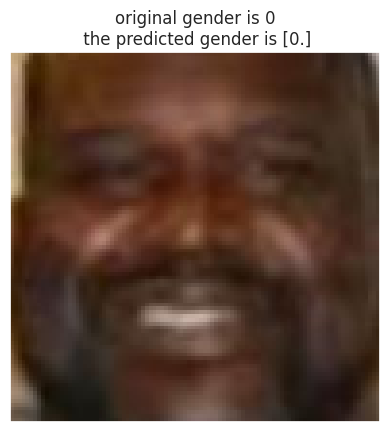

In [37]:
plot_original_predicted_gender(98)

In [38]:
gender_model.save('kaggle_gender_model.h5')